<a href="https://colab.research.google.com/github/aiguozhe01/DIC_Assignment/blob/master/Sprint_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 【問題1】2次元畳み込み層の作成

In [1]:
import numpy as np
from scipy import linalg

In [2]:
# 1フィルタ分の出力を計算
def convolve(X, k):
    # テプリッツ用wを生成
    pad_h = int(X.shape[-2] - k.shape[-2])  # kの高さをXに合わせる
    pad_w = int(X.shape[-1] - k.shape[-1])  # kの幅をXに合わせる
    k_pad = np.pad(k, [(0,0), (0,0), (0, pad_h), (0, pad_w)])  # k(F,C,H,W)

    # 次元削減
    X_flat = np.transpose(X, (0, 2, 1, 3)).reshape(len(X), -1)  # X(N,C,H,W) → X(N,HCW)
    k_flat = np.transpose(k_pad, (0, 2, 1, 3)).flatten()  # k(F,C,H,W) → k(FHCW)

    # テプリッツ行列用の引数を準備
    H, W = X.shape[-2:]
    Hf, Wf = k.shape[-2:]
    Ho, Wo = output_size((H,W), (Hf,Wf))  # 出力サイズを計算
    # 不要な要素行を指定する
    idx = np.arange(H * W).reshape(H, W)
    del_row = idx[..., :H-Hf, W-Wf+1:].flatten()
    # テプリッツの１列目
    first_col = np.r_[k_flat[0], np.zeros(Ho*Wo + len(del_row) - 1)]  
    # テプリッツの１行目
    first_row = k_flat  

    # テプリッツ行列を生成（不要行は削除）
    toep = np.delete(linalg.toeplitz(first_col, first_row), del_row, axis=0)  # toep(HoWo,FHCW)
    
    # フィルタ毎に行列をブロック化し、縦に再結合
    toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FHoWo,HCW)

    # 行列演算
    output = toep_reorder@X_flat.T  # out(FHoWo,N)

    return output.T.reshape(len(X), len(k), Ho, Wo)  # out(N,F,Ho,Wo)

In [3]:
class Conv2d:
    """
    2D Convolution結合
    
    Parameters
    ----------
    filter_size : int
      フィルタのサイズ
    
    Attributes
    ----------
    A_ : 次の形のndarray, shape (N, F, Ho, Wo)
      畳み込み出力
    dZ_ : 次の形のndarray, shape (N, C, H, W)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (F, C, Hf, Wf)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (F)
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, H, W)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Hf, Wf)
          ある層の重み
        b : 次の形のndarray, shape (F)
          ある層のバイアス
        """
        
        self.A_ = self._convolve(Z, w) + b.reshape(1, len(b), 1, 1)  # A(N,F,Ho,Wo)
        
        return self.A_
    
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, H, W)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Hf, Wf)
          ある層の重み
        dA : 次の形のndarray, shape (N, F, Ho, Wo)
          ある層に逆伝播されたAに関するLoss勾配
        """        
        
        # dZ計算
        # チャンネル毎に演算を行うため、行列を転置（NとCを残す）
        w_ = np.transpose(w, (1,0,2,3))  # w(F,C,Hf,Wf) → w(C,F,Hf,Wf)
        w_ = np.flip(w_)  # 上下左右に反転
        # dAをpadding処理
        pad_h = len(w[-2]) - 1
        pad_w = len(w[-1]) - 1
        dA_ = np.pad(dA, [(0,0), (0,0), (pad_h, pad_h), (pad_w, pad_w)])  # HoWo次元のみpadding
        self.dZ_ = self._convolve(dA_, w_)  # dZ(N,C,H,W)
        
        
        # dw計算            
        # フィルタ毎に演算を行うため、行列を転置（FとCを残す）
        Z_ = np.transpose(Z, (1,0,2,3))  # Z(N,C,H,W) → Z(C,N,H,W)
        dA_ = np.transpose(dA, (1,0,2,3))  # dA(N,F,Ho,Wo) → dA(F,N,Ho,Wo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_), (1,0,2,3))  # dw(C,F,Hf,Wf) → dw(F,C,Hf,Wf)
        
        
        # db計算 
        # F以外の次元の和をとる
        self.db_ = np.sum(dA, axis=(0,2,3))  # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    
    def _output_size(self, HW, HfWf, P=0, S=1):
    
        HoWo = (np.array(HW) + 2*P - np.array(HfWf)) / S + 1
        
        return HoWo.astype('int')
    
    def _convolve(self, X, k):
        """
        巡回演算
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H, W)
          巡回される行列
        k : 次の形のndarray, shape (F, C, Hf, Wf)
          巡回する行列
        """
        # テプリッツ用wを生成
        pad_h = int(X.shape[-2] - k.shape[-2])  # kの高さをXに合わせる
        pad_w = int(X.shape[-1] - k.shape[-1])  # kの幅をXに合わせる
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad_h), (0, pad_w)])  # k(F,C,H,W)

        # 次元削減
        X_flat = np.transpose(X, (0, 2, 1, 3)).reshape(len(X), -1)  # X(N,C,H,W) → X(N,HCW) --[1]
        k_flat = np.transpose(k_pad, (0, 2, 1, 3)).flatten()  # k(F,C,H,W) → k(FHCW)

        # テプリッツ行列用の引数を準備
        Ho, Wo = output_size(X.shape[-2:], k.shape[-2:])  # 出力サイズを計算
        # 不要な要素行を指定する
        i = k.shape[-1] - 1
        j = X.shape[-2] - k.shape[-2]
        del_row = []
        for i in range(i):
            del_row.extend(np.arange(i+j+1, X.shape[-2]*j+i+1, X.shape[-2]).astype(list)) 
        # テプリッツの１列目
        first_col = np.r_[k_flat[0], np.zeros(Ho*Wo + len(del_row) - 1)]  
        # テプリッツの１行目
        first_row = k_flat  

        # テプリッツ行列を生成（不要行は削除）
        toep = np.delete(linalg.toeplitz(first_col, first_row), del_row, axis=0)  # toep(HoWo,FHCW)

        # フィルタ毎に行列をブロック化し、縦に再結合
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FHoWo,HCW) --[2]

        # 行列演算（[2]*[1].T）
        output = toep_reorder@X_flat.T  # out(FHoWo,N)

        return output.T.reshape(len(X), len(k), Ho, Wo)  # out(N,F,Ho,Wo)

## 【問題2】2次元畳み込み後の出力サイズ

In [4]:
def output_size(HW, HfWf, P=0, S=1):
    
    # 引数を全てndarrayに変換
    HW = np.array(HW); HfWf = np.array(HfWf); P = np.array(P); S = np.array(S)
    
    # ブロードキャストでHo,Woを算出
    HoWo = (HW + 2*P - HfWf) / S + 1

    return HoWo.astype('int')

In [5]:
output_size((5,5), (3,3))

array([3, 3])

In [6]:
class MaxPool2d:
    def __init__(self, fsize):
        self.fsize = fsize
        self.X_shape = None
        self.rot_shape = None
        self.screen = None
        self.mask = None
        
    def forward(self, X):
        
        self.X_shape = X.shape
        
        H, W = X.shape[-2:]
        Hf, Wf = self.fsize
        
            
        Ho = H // Hf
        Wo = W // Wf

        X_pad = X[..., :Ho*Hf, :Wo*Wf]

        self.screen = X.shape[:-2] + (Ho, Hf, Wo, Wf)  # 6次元
#         pool = np.nanmax(X_pad.reshape(self.screen), axis=(-1,-3))  # Max値取得のためだけなら早い
        
        # 配列をフィルタ毎に再配置し（上下反転後、90度転回）、２次元に落とす
        X_rot = np.flip(np.rot90(X_pad.reshape(self.screen), axes=(3,4)), axis=3)
        X_2d = X_rot.reshape(-1, Hf*Wf)
        self.rot_shape = X_rot.shape  # 逆伝播用にshapeを保存
        
        pool = np.nanmax(X_2d, axis=1).reshape(X.shape[:-2] + (Ho, Wo)) 
        
        # 逆伝播用Mask行列を用意
        self.mask = (X_2d == pool.reshape(-1,1))

        return pool, X_2d, X_rot
        
    def backward(self, dX):

        # 配列をMaskと同じ２次元に落とす
        dpool = np.where(self.mask, dX.reshape(-1,1), 0)  # mask適用

        # 元の形に戻す
        dpool = np.rot90(np.flip(dpool.reshape(self.rot_shape), axis=3), k=3, axes=(3,4))
        
        return dpool.reshape(self.X_shape)

## 【問題4】（アドバンス課題）平均プーリングの作成

In [7]:
class MeanPool2d:

    def __init__(self, fsize):
        self.fsize = fsize
        self.X_shape = None
        self.rot_shape = None
        self.screen = None
        self.mask = None
        
    def forward(self, X):
        
        self.X_shape = X.shape
        
        H, W = X.shape[-2:]
        Hf, Wf = self.fsize
        
            
        Ho = H // Hf
        Wo = W // Wf

        X_pad = X[..., :Ho*Hf, :Wo*Wf]

        self.screen = X.shape[:-2] + (Ho, Hf, Wo, Wf)  # 6次元
        
        # 配列をフィルタ毎に再配置し（上下反転後、90度転回）、２次元に落とす
        X_rot = np.flip(np.rot90(X_pad.reshape(self.screen), axes=(3,4)), axis=3)
        X_2d = X_rot.reshape(-1, Hf*Wf)
        self.rot_shape = X_rot.shape  # 逆伝播用にshapeを保存
        
        pool = np.nanmean(X_2d, axis=1).reshape(X.shape[:-2] + (Ho, Wo)) 
        
        # 逆伝播用Mask行列を用意
        self.mask = np.zeros(X_2d.shape)

        return pool
        
    def backward(self, dX):

        # 配列をMaskと同じ２次元に落とす
        dpool = dX.reshape(-1,1) + self.mask  # 平均値を各poolに振り分ける

        # 元の形に戻す
        dpool = np.rot90(np.flip(dpool.reshape(self.rot_shape), axis=3), k=3, axes=(3,4))
        
        return dpool.reshape(self.X_shape)

## 【問題5】平滑化

In [8]:
class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        
        self.shape = X.shape
        
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,H,W) → X(N,CHW)
    
    def backward(self, dX):
        
        return dX.reshape(self.shape)

【問題6】学習と推定

In [9]:
import time

class SGD:
    """
    確率的勾配降下法
    """
    def __init__(self):
        pass
        
    def update_dw(self, layer, grad):
        """
        ある層の重み勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          重みの勾配
        """
        return grad / layer.input.shape[0]
    
    def update_db(self, layer, grad):
        """
        ある層のバイアス勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_self, )
          バイアスの勾配
        """
        return grad / layer.input.shape[0]
        

class AdaGrad:
    """
    AdaGradによる確率的勾配降下法
    
    Parameters
    ----------
    Hw : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      ある層のイテレーション毎の重み勾配の二乗和
    Hb : 次の形のndarray, shape (n_nodes_self, )
      ある層のイテレーション毎のバイアス勾配の二乗和
    """
    def __init__(self):
        self.Hw = 1e-8
        self.Hb = 1e-8
        
    def update_dw(self, layer, grad):
        """
        ある層の重み勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          重みの勾配
        """
        self.Hw += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hw)) / layer.input.shape[0]
        
        return grad
    
    def update_db(self, layer, grad):
        """
        ある層のバイアス勾配を渡す
        
        Parameters
        ----------
        layer: object instance
          ある層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_self, )
          バイアスの勾配
        """
        self.Hb += (grad/layer.input.shape[0])**2
        grad *= (1/np.sqrt(self.Hb)) / layer.input.shape[0]
        
        return grad
        
        
class Conv2d:
    """
    2D Convolution結合
    
    Parameters
    ----------
    filter_size : int
      フィルタのサイズ
    
    Attributes
    ----------
    A_ : 次の形のndarray, shape (N, F, Ho, Wo)
      畳み込み出力
    dZ_ : 次の形のndarray, shape (N, C, H, W)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (F, C, Hf, Wf)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (F)
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, H, W)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Hf, Wf)
          ある層の重み
        b : 次の形のndarray, shape (F)
          ある層のバイアス
        """
        
        self.A_ = self._convolve(Z, w) + b.reshape(1, len(b), 1, 1)  # A(N,F,Ho,Wo)
        
        return self.A_
    
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (N, C, H, W)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (F, C, Hf, Wf)
          ある層の重み
        dA : 次の形のndarray, shape (N, F, Ho, Wo)
          ある層に逆伝播されたAに関するLoss勾配
        """        
        
        # dZ計算
        # チャンネル毎に演算を行うため、行列を転置（NとCを残す）
        w_ = np.transpose(w, (1,0,2,3))  # w(F,C,Hf,Wf) → w(C,F,Hf,Wf)
        w_ = np.flip(w_)  # 上下左右に反転
        # dAをpadding処理
        pad_h = w.shape[-2] - 1
        pad_w = w.shape[-1] - 1
        dA_ = np.pad(dA, [(0,0), (0,0), (pad_h, pad_h), (pad_w, pad_w)])  # HoWo次元のみpadding
        self.dZ_ = self._convolve(dA_, w_)  # dZ(N,C,H,W)
        
        
        # dw計算            
        # フィルタ毎に演算を行うため、行列を転置（FとCを残す）
        Z_ = np.transpose(Z, (1,0,2,3))  # Z(N,C,H,W) → Z(C,N,H,W)
        dA_ = np.transpose(dA, (1,0,2,3))  # dA(N,F,Ho,Hw) → dA(F,N,Ho,Wo)
        self.dw_ = np.transpose(self._convolve(Z_, dA_), (1,0,2,3))  # dw(C,F,Hf,Wf) → dw(F,C,Hf,Wf)

        
        # db計算 
        # F以外の次元の和をとる
        self.db_ = np.sum(dA, axis=(0,2,3))  # db(F)
        
        return self.dZ_, self.dw_, self.db_
    
    
    def _output_size(self, HW, HfWf, P=0, S=1):
    
        # 引数を全てndarrayに変換
        HW = np.array(HW); HfWf = np.array(HfWf); P = np.array(P); S = np.array(S)

        # ブロードキャストでHo,Woを算出
        HoWo = (HW + 2*P - HfWf) / S + 1   
        
        return HoWo.astype('int')
    
    
    def _convolve(self, X, k):
        """
        巡回演算
        
        Parameters
        ----------
        X : 次の形のndarray, shape (N, C, H, W)
          巡回される行列
        k : 次の形のndarray, shape (F, C, Hf, Wf)
          巡回する行列
        """
        H, W = X.shape[-2:]
        Hf, Wf = k.shape[-2:]
        Ho, Wo = output_size((H,W), (Hf,Wf)) 
        
        # テプリッツ用wを生成
        pad_h = int(H - Hf)  # kの高さをXに合わせる
        pad_w = int(W - Wf)  # kの幅をXに合わせる
        k_pad = np.pad(k, [(0,0), (0,0), (0, pad_h), (0, pad_w)])  # k(F,C,H,W)

        # 次元削減
        X_flat = np.transpose(X, (0, 2, 1, 3)).reshape(len(X), -1)  # X(N,C,H,W) → X(N,HCW)
        k_flat = np.transpose(k_pad, (0, 2, 1, 3)).flatten()  # k(F,C,H,W) → k(FHCW)

        # テプリッツ行列用の引数を準備
        idx = np.arange(H * W).reshape(H, W)  # feature mapと同サイズのインデックス配列を生成
        del_row = idx[..., :H-Hf, W-Wf+1:].flatten()  # 不要な要素行を指定する
        first_col = np.r_[k_flat[0], np.zeros(Ho*Wo + len(del_row) - 1)]  # テプリッツの１列目
        first_row = k_flat  # テプリッツの１行目  

        # テプリッツ行列を生成（不要行は削除）
        toep = np.delete(linalg.toeplitz(first_col, first_row), del_row, axis=0)  # toep(HoWo,FHCW)

        # フィルタ毎に行列をブロック化し、縦に再結合
        toep_reorder = np.vstack(np.split(toep, len(k), axis=1))  #toep(FHoWo,HCW)

        # 行列演算
        output = toep_reorder@X_flat.T  # out(FHoWo,N)

        return output.T.reshape(len(X), len(k), Ho, Wo)  # out(N,F,Ho,Wo)

        
class Affine:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    """
    ハイパーボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_
        
        
class ReLu:
    def __init__(self):
        """
        ReLu関数

        Parameters
        ----------
        Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
          順伝播の出力
        dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
          逆伝播入力に対するdA勾配
        """
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.maximum(A, 0)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * np.where(self.Z_ > 0, 1, 0)
        
        return self.dA_
    
        
class Pool2d:
 
    def __init__(self, fsize, alg='MAX'):
        self.fsize = fsize
        self.alg = alg
        self.X_shape = None
        self.rot_shape = None
        self.screen = None
        self.mask = None
        
    def forward(self, X):
        
        self.X_shape = X.shape
        
        H, W = X.shape[-2:]
        Hf, Wf = self.fsize
        
       
        Ho = H // Hf
        Wo = W // Wf

        X_pad = X[..., :Ho*Hf, :Wo*Wf]

        self.screen = X.shape[:-2] + (Ho, Hf, Wo, Wf)  # 6次元
#         pool = np.nanmax(X_pad.reshape(self.screen), axis=(-1,-3))  # Max値取得のためだけなら早い
        
        # 配列をフィルタ毎に再配置し（上下反転後、90度転回）、２次元に落とす
        X_rot = np.flip(np.rot90(X_pad.reshape(self.screen), axes=(3,4)), axis=3)
        X_2d = X_rot.reshape(-1, Hf*Wf)
        self.rot_shape = X_rot.shape  # 逆伝播用にshapeを保存
        
        if self.alg == 'MAX':
            pool = np.nanmax(X_2d, axis=1).reshape(X.shape[:-2] + (Ho, Wo)) 
            # 逆伝播用Mask行列を用意
            self.mask = (X_2d == pool.reshape(-1,1))
            
        if self.alg == 'MEAN':
            pool = np.nanmean(X_2d, axis=1).reshape(X.shape[:-2] + (Ho, Wo)) 
            # 逆伝播用Mask行列を用意
            self.mask = np.zeros(X_2d.shape)

        return pool
        
    def backward(self, dX):

        # 配列をMaskと同じ２次元に落とす
        if self.alg == 'MAX':
            dpool = np.where(self.mask, dX.reshape(-1,1), 0)  # mask適用
        if self.alg == 'MEAN':
            dpool = dX.reshape(-1,1) + self.mask  # 平均値を各poolに振り分ける

        # 元の形に戻す
        dpool = np.rot90(np.flip(dpool.reshape(self.rot_shape), axis=3), k=3, axes=(3,4))
        
        return dpool.reshape(self.X_shape)
    

class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
          正解ラベルデータ
        """
        self.dA_ = self.Z_ - y
        
        return self.dA_
                    

class Flatten:
    def __init__(self):
        self.shape = None
        
    def forward(self, X):
        
        self.shape = X.shape
        
        return X.reshape(self.shape[0], np.prod(self.shape[1:]))  # X(N,C,H,W) → X(N,CHW)
    
    def backward(self, dX):
        
        return dX.reshape(self.shape)

        
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, shape_self):
        """
        重みの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (shape_self)
        """
        W = self.sigma * np.random.standard_normal(shape_self)
        return W
    
    def B(self, shape_self):
        """
        バイアスの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes_self, )
        """
        B = np.random.randn(n_nodes_self)
        return B
    

class XavierInitializer:
    """
    ザビエルの初期値によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.sigma = None
    
    def W(self, n_nodes_prev, shape_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (shape_self)
        """
        self.sigma = 1 / np.sqrt(np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # tupleを引数にできるstandard_normalを使用
        return W
    
    def B(self, shape_self):
        """
        バイアスの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (shape_self)
        """
        B = np.random.standard_normal(shape_self)
        return B
    
    
class HeInitializer:
    """
    フーの初期値によるシンプルな初期化
    Attributes
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.sigma = None
        
    def W(self, n_nodes_prev, shape_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (shape_self)
        """
        self.sigma = np.sqrt(2/np.prod(n_nodes_prev))
        
        W = self.sigma * np.random.standard_normal(shape_self)  # tupleを引数にできるstandard_normalを使用
        return W
    
    def B(self, shape_self):
        """
        バイアスの初期化
        Parameters
        ----------
        shape_self : 次の形のndarray, shape (shape_self)
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (shape_self)
        """
        B = np.random.standard_normal(shape_self)
        return B
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
    
class Layer:
    """
    層の生成
    
    Parameters
    ----------
    combination : object instance
      結合関数インスタンス
    activation : object instance
      活性化関数インスタンス
    initializer : object instance
      初期化方法のインスタンス
    optimizer : object instance
      最適化手法のインスタンス
    n_nodes_prev : int
      前の層のノード数
    n_nodes_self : int
      自身の層のノード数
      
    Attributes
    ----------
    w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      重みパラメータ
    b : 次の形のndarray, shape (n_nodes_self, )
      バイアスパラメータ
    input : 次の形のndarray, shape (batch_size, n_nodes_prev)
      入力データ
    output : 次の形のndarray, shape (batch_size, n_nodes_self)
      出力データ
    prev : object instance
      前の層
    next : object instance
      後の層
    """
    def __init__(self, combination, activation, 
                 initializer=None, optimizer=None, n_nodes_prev=None, w_shape=None, b_shape=None):
        self.comb = combination
        self.activ = activation
        self.initializer = initializer # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.optimizer = optimizer
        self.n_nodes_prev = n_nodes_prev
        self.w_shape = w_shape
        self.b_shape = b_shape
        self.input = None
        self.output = None
        self.prev = None
        self.next = None
        
        if self.initializer:
            self.w = self.initializer.W(self.n_nodes_prev, self.w_shape)
            self.b = self.initializer.B(self.b_shape)
    
    def forward(self, X):
        """
        順伝播
        
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_prev)
            入力
            
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_self)
            出力
        """        
        if self.comb:
            A = self.comb.forward(X, self.w, self.b)
            Z = self.activ.forward(A)

        else:
            Z = self.activ.forward(X)
        
        self.input = X
        self.output = Z
        
        if self.next:
            return self.next.forward(Z)
        else:
            return Z
    
    def backward(self, y, lr):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
            後ろから流れてきた勾配
        lr : float
          学習率
        """
        if self.comb:
            dA = self.activ.backward(y)
            dZ, dw, db = self.comb.backward(self.input, self.w, dA)
            
            # パラメータ更新
            self.w -= lr * self.optimizer.update_dw(self, dw)
            self.b -= lr * self.optimizer.update_db(self, db)
            
        else:
            dZ = self.activ.backward(y)

        
        if self.prev:
            self.prev.backward(dZ, lr)
        else:
            pass
    
    
class ScratchConvNeuralNetworkClassifier:
    """
    可変層畳み込みニューラルネットワーク分類器

    Parameters
    ----------
    layers : list
      ネットワークに組み込まれる層のリスト
    epoch : int
      エポック数
    sigma : float
      初期パラメータ用（SimpleInitializerのみ適用）
    batch_size : int
      ミニバッチのサンプル数
    verbose : bool
      学習経過の出力

    Attributes
    ----------
    loss_train : list
      訓練データに対するLoss
    loss_val : list
      検証データに対するLoss
    """
    def __init__(self, layers, epoch=100, sigma=0.1, lr=0.01, batch_size=100, verbose=False, **kwargs):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.batch_size = batch_size
        self.loss_train = []
        self.loss_val = []

        # レイヤー同士を結合
        for i, layer in enumerate(layers): 
            if i == 0:
                layer.next = self.layers[i+1]
            elif layer == layers[-1]:
                layer.prev = self.layers[i-1] 
            else:
                layer.next = self.layers[i+1]
                layer.prev = self.layers[i-1]
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, n_classes)
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, n_classes)
            検証データの正解値
        """  
        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            start = time.time()
            
            # 各mini batchの損失をリスト化
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:

                # 順伝播
                output = self.layers[0].forward(X_mini)
                # 逆伝播
                self.layers[-1].backward(y_mini, self.lr)

                loss_batch_t.append(self.cross_entropy(output, y_mini))
            
            # 各epochの平均損失をselfに格納
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # 検証データの推定
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    
                    output = self.layers[0].forward(X_mini)
                
                    loss_batch_v.append(self.cross_entropy(output, y_mini))
            
                # 各epochの平均損失をselfに格納
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)

            end = time.time()
            times.append(end-start)

            # 学習経過の出力
            if self.verbose and (i+1) % 10 == 0:
                print("Epoch {}; Loss {:.4f}".format(i+1, loss_train),
                      "  --Avg Epoch Time {:.4f}sec".format(np.mean(times)))            
                   
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          検証用データ

        Returns
        -------
          次の形のndarray, shape (n_samples, )
          推定結果
        """
        output = self.layers[0].forward(X)
        
        return np.argmax(output, axis=1)
        
    def cross_entropy(self, X, y):
        """
        クロスエントロピー誤差を計算

        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
          入力データ
        y : 次の形のndarray, shape (batch_size, n_classes)
          入力データの正解ラベル

        Returns
        -------
          float
          クロスエントロピー誤差
        """
        return (-1/len(X)) * np.sum((y*np.log(X)))

In [10]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#《データセットをダウンロードするコード》
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Xを標準化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# yをone-hot encode
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
# データを分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
# 特徴量を４次元に変換
X_train = X_train[:, None, :, :]
X_val = X_val[:, None, :, :]
X_test = X_test[:, None, :, :]

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
import matplotlib.pyplot as plt

def plot_loss(model, title='Scratch CNN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

Epoch 10; Loss 0.5626   --Avg Epoch Time 12.0384sec
Epoch 20; Loss 0.3837   --Avg Epoch Time 12.1350sec
Epoch 30; Loss 0.3139   --Avg Epoch Time 12.0542sec
Epoch 40; Loss 0.2765   --Avg Epoch Time 12.1549sec
Epoch 50; Loss 0.2525   --Avg Epoch Time 12.0851sec
Epoch 60; Loss 0.2353   --Avg Epoch Time 12.2374sec
Epoch 70; Loss 0.2240   --Avg Epoch Time 12.2084sec
Epoch 80; Loss 0.2137   --Avg Epoch Time 12.1575sec
Epoch 90; Loss 0.2057   --Avg Epoch Time 11.8751sec
Epoch 100; Loss 0.1992   --Avg Epoch Time 12.0294sec

 Accuracy: 0.939


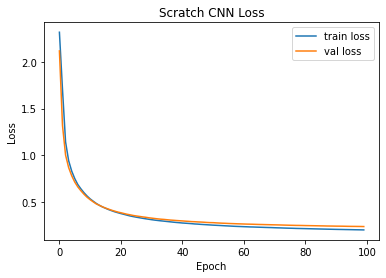

In [12]:
# 5000サンプルで学習

# ハイパーパラメータの設定 w(F,C,Hf,Wf) b(F)
W1 = np.array((5,1,5,5)); B1 = 5
W2 = np.array((320,10)); B2 = 10

# 4層のConvネットワーク
layer_1 = Layer(Conv2d(), ReLu(), HeInitializer(), AdaGrad(), 784, W1, B1)  # 1,28,28 to 5,24,24
layer_2 = Layer(None, Pool2d((3,3))) # 5,24,24 to 5,8,8
layer_3 = Layer(None, Flatten())  # 5,8,8 to 320
output = Layer(Affine(), Softmax(), XavierInitializer(), AdaGrad(), 320, W2, B2)  # 320 to 10

params = {'epoch': 100, 
          'lr': 0.01,
          'batch_size': 200,
          }

cnn = ScratchConvNeuralNetworkClassifier(layers=[layer_1, layer_2, layer_3, output], verbose=True, **params)

cnn.fit(X_train[:5000], y_train[:5000], X_val[:5000], y_val[:5000])

pred = cnn.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(cnn)

Epoch 10; Loss 0.2535   --Avg Epoch Time 105.1018sec
Epoch 20; Loss 0.2144   --Avg Epoch Time 106.2292sec
Epoch 30; Loss 0.1980   --Avg Epoch Time 106.1294sec
Epoch 40; Loss 0.1880   --Avg Epoch Time 106.6545sec
Epoch 50; Loss 0.1811   --Avg Epoch Time 105.5445sec

 Accuracy: 0.9496


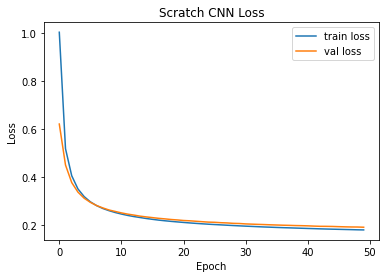

In [13]:
# 全てのデータで学習

# ハイパーパラメータの設定 w(F,C,Hf,Wf) b(F)
W1 = np.array((5,1,5,5)); B1 = 5
W2 = np.array((320,10)); B2 = 10

# 4層のConvネットワーク
layer_1 = Layer(Conv2d(), ReLu(), HeInitializer(), AdaGrad(), 784, W1, B1)  # 1,28,28 to 5,24,24
layer_2 = Layer(None, Pool2d((3,3))) # 5,24,24 to 5,8,8
layer_3 = Layer(None, Flatten())  # 5,8,8 to 320
output = Layer(Affine(), Softmax(), XavierInitializer(), AdaGrad(), 320, W2, B2)  # 320 to 10

params = {'epoch': 50, 
          'lr': 0.01,
          'batch_size': 200,
          }

cnn = ScratchConvNeuralNetworkClassifier(layers=[layer_1, layer_2, layer_3, output], verbose=True, **params)

cnn.fit(X_train, y_train, X_val, y_val)

pred = cnn.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(cnn)